In [2]:
from tensorflow.python.client import device_lib
import tensorflow as tf
from skill_label_classifier import *
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# helper function to find optimal number of PC (elbow method)
def plot_explained_variance(X_train):
    pca = PCA()
    pca_full = pca.fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()
    
def preprocess_pca(X_train, X_test, dim, r=None):
    pca = PCA(n_components=dim, random_state=r)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


experiment = SkillClassifier()
experiment.import_data()
experiment.create_df()

experiment.choose_dataset('vqa')
# experiment.set_features(['QSN', 'descriptions', 'tags', 'dominant_colors','handwritten_text', 'ocr_text'])
experiment.set_features(['dominant_colors'])
experiment.set_targets()

features_train = experiment.features_train
features_val   = experiment.features_val

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17196846669855423687
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11285289370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2358246800020234531
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 4719:00:00.0, compute capability: 3.7"
]
['/job:localhost/replica:0/task:0/device:GPU:0']
Joined features with skill labels.
Joined features with skill labels.
Joined features with skill labels.
Joined features with skill labels.
VizWiz training shape: (14257, 13)
VQA training shape: (3230, 13)
Total training rows: 17487
VizWiz validation shape:(2247, 13)
VQA validation shape:(513, 13)
Total validation rows: 2760
Training: (3230, 13)
Validation: (513, 13)


In [3]:
# check training class distribution
text_recognition_y_train = np.asarray(experiment.txt_train).astype('float32')
color_recognition_y_train = np.asarray(experiment.col_train).astype('float32')
counting_y_train = np.asarray(experiment.cnt_train).astype('float32')

print('Number of training samples each class: ')
print('Text recognition - 1: {} 0: {}'.format(np.count_nonzero(text_recognition_y_train), 
      len(text_recognition_y_train)-np.count_nonzero(text_recognition_y_train)))
print('Color recognition - 1:{} 0: {}'.format(np.count_nonzero(color_recognition_y_train),
      len(color_recognition_y_train)-np.count_nonzero(color_recognition_y_train)))
print('Counting - 1: {} 0: {}'.format(np.count_nonzero(counting_y_train), 
      len(counting_y_train)-np.count_nonzero(counting_y_train)))

n_classes = 3

y_train = np.column_stack((text_recognition_y_train, color_recognition_y_train, counting_y_train))

# check validation class distribution
text_recognition_y_val = np.asarray(experiment.txt_val).astype('float32')
color_recognition_y_val = np.asarray(experiment.col_val).astype('float32')
counting_y_val = np.asarray(experiment.cnt_val).astype('float32')
print('Number of validation samples each class: ')
print('Text recognition - 1: {} 0: {}'.format(np.count_nonzero(text_recognition_y_val), 
      len(text_recognition_y_val)-np.count_nonzero(text_recognition_y_val)))
print('Color recognition - 1:{} 0: {}'.format(np.count_nonzero(color_recognition_y_val),
     len(color_recognition_y_val)-np.count_nonzero(color_recognition_y_val)))
print('Counting - 1:{} 0: {}'.format(np.count_nonzero(counting_y_val),
     len(counting_y_val)-np.count_nonzero(counting_y_val)))

y_val = np.column_stack((text_recognition_y_val, color_recognition_y_val, counting_y_val))

# tokenize
tok         = Tokenizer(num_words=VOCAB_SIZE, 
                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                       lower=True,
                       split=" ")
tok.fit_on_texts(features_train)

# create training and validation sequences
MAX_DOC_LEN = 40
train_seq   = tok.texts_to_sequences(features_train)
val_seq     = tok.texts_to_sequences(features_val)
# pad training and validation sequences
train_seq        = sequence.pad_sequences(train_seq, maxlen=MAX_DOC_LEN)
val_seq          = sequence.pad_sequences(val_seq, maxlen=MAX_DOC_LEN)

# standardize training and testing features
sc = StandardScaler()
train_seq = sc.fit_transform(train_seq)
val_seq = sc.transform(val_seq)

# Set validation data tuple
val_data = (val_seq, y_val)

# punkt sentence level tokenizer
sent_lst = [] 
for doc in features_train:
    sentences = nltk.tokenize.sent_tokenize(doc)
    for sent in sentences:
        word_lst = [w for w in nltk.tokenize.word_tokenize(sent) if w.isalnum()]
        sent_lst.append(word_lst)

googlenews_corpus = '/anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin'
        
# load pre-trained word2vec on GoogleNews (https://code.google.com/archive/p/word2vec/)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format(datapath(googlenews_corpus),
                                                                 binary=True)
embeddings_index = {}
for word in word2vec_model.wv.vocab:
    coefs = np.asarray(word2vec_model.wv[word], dtype='float32')
    embeddings_index[word] = coefs
print('Total %s word vectors' % len(embeddings_index))

# Initial word embedding
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None and i < VOCAB_SIZE:
        embedding_matrix[i] = embedding_vector

# PCA to reduce dimensionality
N_COMPONENTS = MAX_DOC_LEN
train_seq, val_seq = preprocess_pca(train_seq, val_seq, dim=N_COMPONENTS)

Number of training samples each class: 
Text recognition - 1: 358 0: 2872
Color recognition - 1:1148 0: 2082
Counting - 1: 661 0: 2569
Number of validation samples each class: 
Text recognition - 1: 63 0: 450
Color recognition - 1:179 0: 334
Counting - 1:109 0: 404


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
2019-04-07 17:54:08,589 : INFO : loading projection weights from /anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin
2019-04-07 17:54:50,070 : INFO : loaded (3000000, 300) matrix from /anaconda/envs/py35/lib/python3.5/site-packages/gensim/test/test_data/GoogleNews-vectors-negative300.bin
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:70: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:71: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


Total 3000000 word vectors


# GPU, VQA, test individual features for counting

In [ ]:
L = 1e-1
B = 32
E = 250
model, history = lstm_create_train(MAX_DOC_LEN, train_seq, embedding_matrix,
                 train_labels=y_train,
                 val_data=val_data,
                 learning_rate=L,
                 lstm_dim=100,
                 batch_size=B,
                 num_epochs=E,
                 optimizer_param=SGD(lr=L, nesterov=True),
                 n_classes=3)

Log file: ./LSTM/0.1_1e-07_32_250.log


In [ ]:
preds = model.predict(val_seq, verbose=0)
y_pred_text = [1 if i >= 0.5 else 0 for i in preds[:,0]]
y_pred_color = [1 if i >= 0.5 else 0 for i in preds[:,1]]
y_pred_counting = [1 if i >= 0.5 else 0 for i in preds[:,2]]
print("VQA, all features - accuracy\ntext: {}\ncolor:{}\ncounting:{}".format(accuracy_score(y_val[:,0], y_pred_text),
                                                        accuracy_score(y_val[:,1], y_pred_color),
                                                        accuracy_score(y_val[:,2], y_pred_counting)))
print("Counting - AUC:", roc_auc_score(y_val[:,2], y_pred_counting))

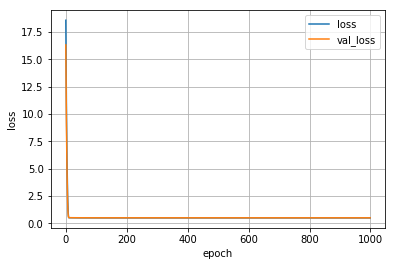

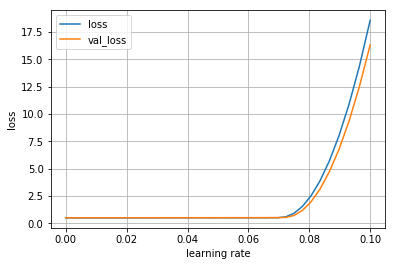

In [7]:
log = pd.read_csv("./LSTM/0.1_(0.001, 0.001)_32_1000.log")
plt.plot(log['epoch'].values, log['loss'].values, label='loss')
plt.plot(log['epoch'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid()
plt.show()

plt.plot(log['lr'].values, log['loss'].values, label='loss')
plt.plot(log['lr'].values, log['val_loss'].values, label='val_loss')
plt.legend()
plt.xlabel("learning rate")
plt.ylabel("loss")
plt.grid()
plt.show()